<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/1_data_pipelining_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended:  8th May, 2021
# My folder:    /home/ashok/Documents/5.decisiontree
# VM: lubuntu_machinelearning_I
# Ref Why dummy encoding:
#        https://www.statisticssolutions.com/dummy-coding-the-how-and-why/

# Objectives:
#     i)    Read and explore data
#    ii)    Deal with missing values 
#   iii)    OneHotEncode categorical features
#    iv)    Use Pipeline and ColumnTransformer 
#           for data transformation
#    v)     Pipeline for modeling
#    vi)    Nested pipes

In [1]:
# 0.0 Install recent version of sklearn for
#     visualizing pipelines

!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 1.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


### Call libraries


In [2]:
# 1.0 Reset memory
#%reset -f
# 1.1 Call libraries

## Data manipulation
import numpy as np
import pandas as pd

# 1.2 for data splitting
from sklearn.model_selection import train_test_split

## Transformers:
# 1.3 Class for imputing missing values
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer

# 1.4 One hot encode categorical data--Convert to dummy
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder as onehot

# 1.5 Label encode target column
from sklearn.preprocessing import LabelEncoder

# 1.6 Scale numeric data
from sklearn.preprocessing import StandardScaler


## Composite Transformers
# 1.7 Class for applying multiple data transformation jobs
from sklearn.compose import ColumnTransformer

# 1.8 Pipeline class
from sklearn.pipeline import Pipeline

# 1.9 Estimator
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# User guide: https://scikit-learn.org/stable/modules/tree.html
from sklearn.tree import DecisionTreeClassifier 

# 1.10 To plot pipeline diagram
from sklearn import set_config

In [3]:
# 1.11 Display outputs of all commands from a cell--not just of the last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# 2.0 Import warnings module
import warnings
# 2.1 Do not print warnings on screen
warnings.filterwarnings("ignore")

### Read and preprocess data
Read data, create simple cat features and shuffle data

In [5]:
# 3.0 Create a toy dataset with six columns
#     Every column has at least one NaN except column: 'creditability'
#     'creditability' is our target column so no NaN
df = pd.DataFrame({
                    'creditability' : ['yes','yes','yes','yes','yes','yes','no','no','no','no','no','no','no','no'], # Target column
                    'acc_balance'   : [1,2,1,np.nan,1,2,1,2,1,2,2,np.nan,np.nan,np.nan],
                    'house_owned'   : ['big','small',np.nan,'small','big',np.nan,np.nan,'big','small','big','big','small',np.nan,'small'],
                    'age'           : [21,45,np.nan,40,34,89,23,65,87,np.nan,90,np.nan,60,np.nan],
                    'income'        : [np.nan,7.8,3.4,5.5,2.1,8.9,3.9,np.nan,6.9,9.0,np.nan,8.0,8.5,np.nan],  
                    'credit_amount' : [1011,np.nan,3211,np.nan,1000,2323,1010,1500,1300,1782,1212,np.nan,1232,np.nan]
                  }
               )

df    # (14,6)

,creditability,acc_balance,house_owned,age,income,credit_amount
0,yes,1.0,big,21.0,NaN,1011.0
1,yes,2.0,small,45.0,7.8,NaN
2,yes,1.0,NaN,NaN,3.4,3211.0
3,yes,NaN,small,40.0,5.5,NaN
4,yes,1.0,big,34.0,2.1,1000.0
5,yes,2.0,NaN,89.0,8.9,2323.0
6,no,1.0,NaN,23.0,3.9,1010.0
7,no,2.0,big,65.0,NaN,1500.0
8,no,1.0,small,87.0,6.9,1300.0
9,no,2.0,big,NaN,9.0,1782.0


In [6]:
# 3.1 Engineer some new categorical features from 'age' and 'credit_amount'
#     We will have NaN values both in 'age_cat' and 'credit_amount_cat' columns
#     (Note: Strictly speaking this method of creating features outside pipeline is 
#     not recommended as it leaks information about X_test (to be created, see below)
#     to X_train. Recommended way is to wrap it up inside sklearn's FunctionTransformer
#     and then use wrapped transformer within a processing pipeline. See:
#     https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers)
#     Else, use KBinsDiscretizer of sklearn

df['age_cat'] = pd.cut(df['age'],               # Equal interval cuts between min and max
                       3,                       # Three cuts
                       labels=["1","2", "3"]    # Label for each cut
                       )

# 3.1.1
df['credit_amount_cat'] = pd.qcut(df['credit_amount'],       # Equal freq cut
                                  3,
                                  labels=["low","medium", "high"])
df   # (13,8)


,creditability,acc_balance,house_owned,age,income,credit_amount,age_cat,credit_amount_cat
0,yes,1.0,big,21.0,NaN,1011.0,1,low
1,yes,2.0,small,45.0,7.8,NaN,2,NaN
2,yes,1.0,NaN,NaN,3.4,3211.0,NaN,high
3,yes,NaN,small,40.0,5.5,NaN,1,NaN
4,yes,1.0,big,34.0,2.1,1000.0,1,low
5,yes,2.0,NaN,89.0,8.9,2323.0,3,high
6,no,1.0,NaN,23.0,3.9,1010.0,1,low
7,no,2.0,big,65.0,NaN,1500.0,2,medium
8,no,1.0,small,87.0,6.9,1300.0,3,medium
9,no,2.0,big,NaN,9.0,1782.0,NaN,high


In [7]:
# 3.2 Randomly shuffle data as values 
#     in 'credibility' column have an order
df = df.sample(frac = 1) 
df    # (13,8)

,creditability,acc_balance,house_owned,age,income,credit_amount,age_cat,credit_amount_cat
3,yes,NaN,small,40.0,5.5,NaN,1,NaN
0,yes,1.0,big,21.0,NaN,1011.0,1,low
4,yes,1.0,big,34.0,2.1,1000.0,1,low
10,no,2.0,big,90.0,NaN,1212.0,3,low
1,yes,2.0,small,45.0,7.8,NaN,2,NaN
13,no,NaN,small,NaN,NaN,NaN,NaN,NaN
9,no,2.0,big,NaN,9.0,1782.0,NaN,high
8,no,1.0,small,87.0,6.9,1300.0,3,medium
7,no,2.0,big,65.0,NaN,1500.0,2,medium
11,no,NaN,small,NaN,8.0,NaN,NaN,NaN


### Data splitting
Separate predictors and target. Create train/test data.

In [8]:
# 3.3    Popout target
#        to separate predictors and target

y = df.pop('creditability')
y[:3]      # Pandas Series

# 3.4   Create an alias of predictors dataset 
X = df     # X is another name for df
X.shape    # (13,7)

3    yes
0    yes
4    yes
Name: creditability, dtype: object

(14, 7)

In [41]:
# 4.0 Split dataset. We will preprocess X_train and apply that
#     processing to X_test later
X_train,X_test, y_train, y_test = train_test_split(
                                                    X,                   # Data features
                                                    y,                   # Target column
                                                    test_size = 0.2      # split-ratio
                                                    )

# 4.1 Note the use of f-string for printing
f"X_train shape: {X_train.shape}"    # (11,7)
print()
f"X_test.shape : {X_test.shape}"     # (3,7)
print()
f"y_train shape: {y_train.shape}"    # (11,)
print()
f"y_test shape : {y_test.shape}"     # (3,)

'X_train shape: (11, 7)'

'X_test.shape : (3, 7)'

'y_train shape: (11,)'

'y_test shape : (3,)'

### Separate out categorical and numerical features

Categorical features processing:
-  Imputation 
> - Impute most-frequent value
> - Impute constant value
- Encoding
> -  Target encoding of target only
> -  OneHotEncoding of rest features

Numeric features processing
-  Imputation 
> - Impute median
> - Impute mean
- Scaling
> -  Min-Max or StandardScaling

In [42]:
### 4.3
###    Which columns are categorical
###    but disguised as integers

# 4.3 How many unique values per column.
#     Check every column
#     We will assume that if number of unique values
#      are 4 or less it is categorical column else numeric

f"Total no of unique values per column are:" ; print()
X_train.nunique()        # Total no of unique values in each column

# 4.4 If no. of unique values less than 5, it is categorical
print("\n------\n")
f"True are categorical and False are numerical:" ; print()
X_train.nunique() < 5    # All True are categorical


'Total no of unique values per column are:'

acc_balance          2
house_owned          2
age                  8
income               7
credit_amount        9
age_cat              3
credit_amount_cat    3
dtype: int64


------



'True are categorical and False are numerical:'

acc_balance           True
house_owned           True
age                  False
income               False
credit_amount        False
age_cat               True
credit_amount_cat     True
dtype: bool

In [43]:
# 4.5 Extract list of cat_cols and num_cols:

# 4.6 First note which are cat and which are num
dg = (X_train.nunique() < 5)  
dg    # All True are cat and all False are num

# 4.7 Then filter out names from Series index 
cat_cols = dg[dg==True].index.tolist()
num_cols = dg[dg==False].index.tolist()

acc_balance           True
house_owned           True
age                  False
income               False
credit_amount        False
age_cat               True
credit_amount_cat     True
dtype: bool

In [44]:
# 4.8 Here are the columns
cat_cols    #  4
print()
num_cols    #  3

['acc_balance', 'house_owned', 'age_cat', 'credit_amount_cat']

['age', 'income', 'credit_amount']

In [45]:
# 4.9 We will create two subsets of num_cols
#      One set we will impute using 'mean' 
#       and the other using 'median'

num_cols_mean   = ['age']
num_cols_median = ['income', 'credit_amount']

In [46]:
# 4.10 We will create two sets of cat_cols
#      One set we will fill with 'most_frequent'
#       and the other using a constant value

cat_cols_mf       = ['acc_balance', 'house_owned']       # 'most_frequent' fill
cat_cols_const    = ['age_cat', 'credit_amount_cat']     # 'constant' fill

#### Our four data subsets
> Numeric with mean imputation<br>
> Numeric with nedian imputation<br>
> Categorical with mode imputation<br>
> Categorical with constant imputation<br>

In [47]:
# 4.11 So we have four datasets for imputing: These are:
X_train[num_cols_mean]              # Num dataset, impute by 'mean'   strategy
X_train[num_cols_median]            # Num dataset, impute by 'median' strategy
X_train[cat_cols_mf]                # Cat dataset, impute by 'most_frequent' strategy
X_train[cat_cols_const]             # Cat dataset, impute by 'constant' strategy

,age
7,65.0
3,40.0
0,21.0
13,NaN
12,60.0
9,NaN
8,87.0
2,NaN
6,23.0
5,89.0


,income,credit_amount
7,NaN,1500.0
3,5.5,NaN
0,NaN,1011.0
13,NaN,NaN
12,8.5,1232.0
9,9.0,1782.0
8,6.9,1300.0
2,3.4,3211.0
6,3.9,1010.0
5,8.9,2323.0


,acc_balance,house_owned
7,2.0,big
3,NaN,small
0,1.0,big
13,NaN,small
12,NaN,NaN
9,2.0,big
8,1.0,small
2,1.0,NaN
6,1.0,NaN
5,2.0,NaN


,age_cat,credit_amount_cat
7,2,medium
3,1,NaN
0,1,low
13,NaN,NaN
12,2,medium
9,NaN,high
8,3,medium
2,NaN,high
6,1,low
5,3,high


In [48]:
# 4.2   Make a copy of X_train
#       and X_test for two separate
#       ways of data processing
#       without using pipes and with pipes

X_train_c = X_train.copy()
X_test_c  = X_test.copy()

## Part I

Data preprocessing without Pipelining
Pre-process each one of the four subsets of data separately. And finally manually concatenate all results to create final dataset. We will henceforth use two terms:<br>
<ul>
    <li>
    transformers: Which transform a dataset. Examples: <i>StandardScaler()</i>, <i>Normalizer()</i>, <i>SimpleImputer()</i>,  <i>OneHotEncoder()</i>, <i>PipeLine()</i>, <i>ColumnTransformer()</i>. Transformers have <i>fit()</i>, <i>transform()</i> and <i>fit_transform()</i> methods. Transformers do not make any predictions and hence there is no <i>predict()</i> method.
    </li>
    <li>
estimators:   Which estimate the pattern in a data. Example: <i>DecisionTreeClassifier</i>, <i>KMeans</i>, <i>GMM</i>.      Estimators have <i>fit()</i> and <i>predict()</i> methods. There is no need for any transformation and hence there is no <i>transform()</i> method.
</ul></li>


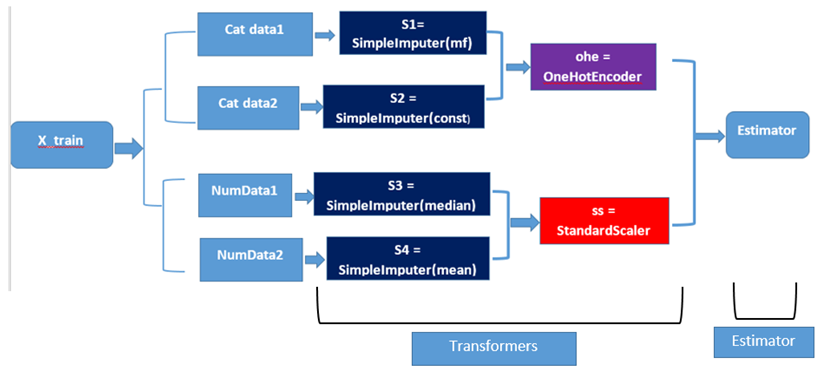

### Impute missing values

#### Impute in two subsets of numeric data
Impute NaN first in two data subsets: `num_cols_median` and `num_cols_mean`. Our class-objects will be `si_median` and `si_mean`.


In [49]:
## 5.1 Instantiate 

# 5.1.1 Instantiate SimpleImputer class
#        with two difft strategies to
#         create two objects. 

si_median = SimpleImputer(strategy = 'median')
si_mean   = SimpleImputer(strategy = 'mean')

# 5.1.2 Next, use the two objects to fit 
#       and transform respective datasets:

X_train_c[num_cols_median] = si_median.fit_transform(
                                                     X_train_c[num_cols_median]
                                                     )

X_train_c[num_cols_mean] = si_mean.fit_transform(
                                                  X_train_c[num_cols_mean]
                                                 )



In [50]:
# 5.2 Observe results of two transformations.
#     There should be no NaNs

X_train_c[num_cols_median]
print()
X_train_c[num_cols_mean]

,income,credit_amount
7,6.9,1500.0
3,5.5,1300.0
0,6.9,1011.0
13,6.9,1300.0
12,8.5,1232.0
9,9.0,1782.0
8,6.9,1300.0
2,3.4,3211.0
6,3.9,1010.0
5,8.9,2323.0


,age
7,65.000
3,40.000
0,21.000
13,59.375
12,60.000
9,59.375
8,87.000
2,59.375
6,23.000
5,89.000


#### Impute in two subsets of categorical data next

In [51]:
# 5.3 Similarly create two objects
#     to impute data in categorical 
#     data-subsets.

si_mf = SimpleImputer(strategy = 'most_frequent')

si_const = SimpleImputer(
                          strategy = 'constant',
                          fill_value = 'missing'  # fill with const value 'missing'
                        )

# 5.3.1 Use the two objects to transform
#       the respective two data-subsets:

X_train_c[cat_cols_mf] = si_mf.fit_transform(
                                             X_train_c[cat_cols_mf]
                                             )

X_train_c[cat_cols_const] = si_const.fit_transform(
                                                    X_train_c[cat_cols_const]
                                                   )

In [52]:
# 5.4 Observer the results of transformation
#     in two data-subsets

X_train_c[cat_cols_const]
print()
X_train_c[cat_cols_mf]

,age_cat,credit_amount_cat
7,2,medium
3,1,missing
0,1,low
13,missing,missing
12,2,medium
9,missing,high
8,3,medium
2,missing,high
6,1,low
5,3,high


,acc_balance,house_owned
7,2.0,big
3,1.0,small
0,1.0,big
13,1.0,small
12,1.0,big
9,2.0,big
8,1.0,small
2,1.0,big
6,1.0,big
5,2.0,big


In [53]:
## A Summary
# 5.5 So our fitted transformers are:

si_median         # To transform num_cols_median
si_mean           # To transform num_cols_mean
si_mf             # To transform cat_cols_mf
si_const          # To transform cat_cols_constant

# 5.6 Our column-colections are:

cat_cols          # cat_cols_mf + cat_cols_constant
num_cols          # num_cols_mean + num_cols_median

# 5.6.1
cat_cols_mf
cat_cols_const
num_cols_mean
num_cols_median

# 5.7 Our datasets are:

X_train_c[:2],X_test_c[:2],y_train[:2],y_test[:2]

SimpleImputer(strategy='median')

SimpleImputer()

SimpleImputer(strategy='most_frequent')

SimpleImputer(fill_value='missing', strategy='constant')

['acc_balance', 'house_owned', 'age_cat', 'credit_amount_cat']

['age', 'income', 'credit_amount']

['acc_balance', 'house_owned']

['age_cat', 'credit_amount_cat']

['age']

['income', 'credit_amount']

(   acc_balance house_owned   age  ...  credit_amount  age_cat credit_amount_cat
 7          2.0         big  65.0  ...         1500.0        2            medium
 3          1.0       small  40.0  ...         1300.0        1           missing
 
 [2 rows x 7 columns],
     acc_balance house_owned   age  ...  credit_amount  age_cat credit_amount_cat
 4           1.0         big  34.0  ...         1000.0        1               low
 11          NaN       small   NaN  ...            NaN      NaN               NaN
 
 [2 rows x 7 columns],
 7     no
 3    yes
 Name: creditability, dtype: object,
 4     yes
 11     no
 Name: creditability, dtype: object)

### OneHotEncoding

#### What does OHE do?

##### sparse = False

In [54]:
# 6.0 What does OneHotEncoder do?
#     Demo with 'sparse = False'

# 6.1 Instantiate onehot class.
#     Our object name is 'abc' 

abc = onehot(sparse = False)

# 6.2 Let 'abc' learn relevant data
#     properties. Our demo data is: 4 X 2
#     Both columns are categorical:

abc.fit(
         [                            # A list of lists
            ['big'   , 'yes' ],
            ['small' , 'no'  ],
            ['medium', 'yes' ],
            ['big'   , 'no'  ]
         ]
       )

# 6.3 Use 'abc' object to transform demo data
#     to dummy values

abc.transform(
              [                     
                ['big'   , 'yes' ],
                ['small' , 'no'  ],
                ['medium', 'yes' ],
                ['big'   , 'no'  ]
              ]
             )



OneHotEncoder(sparse=False)

array([[1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

In [55]:
# 6.4 In future use 'abc' to tansform 
#     any data with such levels.
#     For example:

abc.transform(
               [
                   ['small'  , 'yes'],
                   ['medium' , 'no' ]
               ])

array([[0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0.]])

##### sparse = True

In [56]:
# 6.5 What does OneHotEncoder do?
#     In one line, it transforms dense data to dummy values (1,0)
#     Demo with 'sparse = True' -- Output is stored in a special compressed format
#     See here dense matrix to sparse matrix conversion example:
#     http://www.btechsmartclass.com/data_structures/ds_images/Triplet_Representation_of_Sparse_Matrix.png
#     https://www.researchgate.net/publication/328995968/figure/fig4/AS:693582436528129@1542374347304/Illustration-of-the-sparse-matrix-format-A-Example-matrix-of-size-8-8-with-5.png

# 6.5.1

cde = onehot(sparse = True)


# 6.5.2
sp = cde.fit_transform(
                       [
                        ['big', 'yes'],
                        ['small', 'no'],
                        ['medium', 'yes'],
                        ['big','no']
                        ]
                       )

# 6.5.3
sp


<4x5 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [57]:
# 6.5.4  Transform sparse to dense form
sp.toarray()

array([[1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

#### OHE for our train data:
Let us now transform ALL our cat_cols to OHE.

In [58]:
# 6.6 One Hot Encode all categorical columns, cat_cols 
#     Note, by now all NaNs have been filled

ohe = onehot(sparse = False)
ohe.fit_transform(X_train_c[cat_cols])

array([[0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]])

### Standard scaling all numeric columns
Scale all numeric columns

In [59]:
# 6.7 Scale all numeric variables in the same manner
#     Note, by now all NaNs have been dealth with

ss = StandardScaler()
ss.fit_transform(X_train_c[num_cols])

array([[ 0.24534913,  0.11419676, -0.09792913],
       [-0.84509144, -0.68518059, -0.41429343],
       [-1.67382628,  0.11419676, -0.87143985],
       [ 0.        ,  0.11419676, -0.41429343],
       [ 0.02726101,  1.02777088, -0.5218573 ],
       [ 0.        ,  1.31326279,  0.34814453],
       [ 1.20493683,  0.11419676, -0.41429343],
       [ 0.        , -1.88424661,  2.60856748],
       [-1.58659103, -1.5987547 , -0.87302167],
       [ 1.29217208,  1.25616441,  1.20390997],
       [ 1.3357897 ,  0.11419676, -0.55349373]])

### Should OHE features be standardized?






There is quite a lot of discussion on it. Please see the following StackOverflow answers:  

[Do I need to standardize my one hot encoded labels?](https://datascience.stackexchange.com/a/56452/64849)   

[Ridge\Lasso — Standardization of dummy indicators](https://stats.stackexchange.com/a/359370/78454)

Very briefly: If OHE features are standardized then model interpretation becomes difficult. But if they are not, then all features are not on the same scale (ie mean = 0, variance =1). Let performance be the final judge. Try with and without standardizing OHE features.

### Concatenate pre-processed data

In [60]:
# 7.0 So complete dataset is:
a = ohe.transform(X_train_c[cat_cols])
b = ss.transform(X_train_c[num_cols])

# 7.1 Horizontally concatenate now
Xtr = np.hstack([a,b]) # It is not X_train
Xtr.shape # (8,14)

(11, 15)

### Label encoding target
Code text values in target column to digits. Our <i>y_train</i> (<i>'Creditability'</i> column) has values 'yes', 'no'...

In [61]:
# 8.0 Label encode target feature
# 8.0.1 Our target
f"Unencoded target column is:"
y_train

# 8.0.2 Encode now
le = LabelEncoder()
le.fit(y_train)

y_train = le.fit_transform(y_train)

# 8.0.3 Just print transformed y_train
print()
f"Encoded y_train is: {y_train}"   # Encoded y

'Unencoded target column is:'

7      no
3     yes
0     yes
13     no
12     no
9      no
8      no
2     yes
6      no
5     yes
10     no
Name: creditability, dtype: object

LabelEncoder()

'Encoded y_train is: [0 1 1 0 0 0 0 1 0 1 0]'

### Decision tree Modeling

In [62]:
# 9.0 Train model using Xtrain
from sklearn.tree import DecisionTreeClassifier 

# 9.1 Instantiate DecisionTreeClassifier class

dt = DecisionTreeClassifier()

# 9.2 Use the classifier object to train 
#     on our data

dt.fit(Xtr,y_train)


DecisionTreeClassifier()

### Make predictions

#### Transform X_test_c
Before making predictions, we need to tranform columns of <i>X_test_c</i> in the same manner we did to X_train

In [63]:
# 9.3 We now want to predict values for X_test_c

# 9.4 First, transform X_test_c in the same manner as we did for X_train
#      But this time, there will be no 'fit()'. We will use
#       already fitted objects for transformations.

#     NOTE: If you have find the error of there being new levels in Xtest,
#           execute all code quickly from #4.0 onwards.

X_test_c[num_cols_median]  = si_median.transform(X_test_c[num_cols_median])
X_test_c[num_cols_mean]    = si_mean.transform(X_test_c[num_cols_mean])
X_test_c[cat_cols_const]   = si_const.transform(X_test_c[cat_cols_const])
X_test_c[cat_cols_mf]      = si_mf.transform(X_test_c[cat_cols_mf]) 
a                          = ohe.transform(X_test_c[cat_cols])
b                          = ss.transform(X_test_c[num_cols])
Xtest = np.hstack([a,b])   # Final transformed X_test

In [64]:
# 9.5 Also label encode, y_test
#     Using earlier fitted 'le' object
f"Values in y_test are:"
y_test

y_test = le.transform(y_test)
f"Transformed y_test is: {y_test}"

'Values in y_test are:'

4     yes
11     no
1     yes
Name: creditability, dtype: object

'Transformed y_test is: [1 0 1]'

#### Make predictions

In [65]:
# 9.6 Make prediction for Xtest
dt.predict(Xtest)

array([0, 0, 0])

## Part II
## Data pre-processing with Pipelining
Pipelining has two advantages:
> 1. It avoids intermediate variables
> 2. It avoids data leakage

As you create a pipe (say, pipe1) test it if it is working. Our big-picture of all plumbing is as below. 

```
Pipeline(
           [
            ColumnTransformer(
                              [ 
                                pipe1,
                                pipe2,
                                pipe3,
                                pipe4
                             ],
           DecisionTreeClassifier            
          ]
        ) 
```


                     

Here is another complete diagram. 

**Impt:** As you build pipes, go on testing them (just as a plumber would do) before you join all of them together.

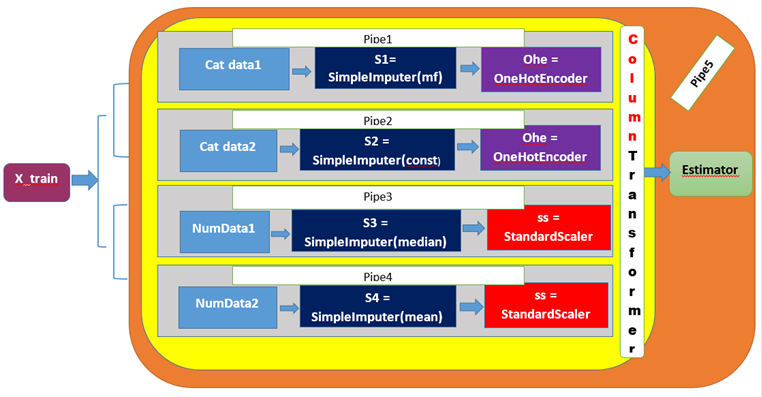

In [ ]:
# 10.0 Create pipes for all transformations
# Ref: https://scikit-learn.org/stable/modules/compose.html#pipeline

#     ColumnTransformer: Applies specified transformations parallely to each data-subset
#     Pipeline         :  Applies transformation sequentially through transformers. 
#                         Input to pipe is one data-subset. Output of one transformer
#                         is fed to another.

#     A pipeline can be used as any other estimator
#     and avoids leaking the test set into the train set

Pipeline syntax is as below. Pipes operate sequentially.

```
    Pipeline (
              [ 
                 ("transf1 name", transformer1),
                 ("transf2 name", transformer2)
              ]
            )
            
```




In [67]:
# 10.1 Instantiate Pipeline object for processing
#      cat data. Impute = most_frequent

pipe1  =  Pipeline(
                     [
                      ('mf', SimpleImputer(strategy='most_frequent')),
                      ('ohe', onehot())
                     ]
                   )

In [68]:
# 10.2 Instantiate SimpleImputer object for processing
#      cat data. Impute = constant

sc = SimpleImputer(strategy="constant", fill_value = 'missing')

# 10.2.1 Ceate pipeline object:

pipe2   = Pipeline(
                    [
                      ('cons', sc),
                      ('ohe', onehot())
                    ]
                  )

In [69]:
# 10.3 Instantiate Pipeline object for 
#      processing numerical data. Impute = median

pipe3    = Pipeline(
                     [
                      ('sm', SimpleImputer(strategy='median')),
                      ('ss2', StandardScaler())
                     ]
                  )

In [70]:
# 10.4 Instantiate Pipeline object for 
#      processing numerical data. Impute = mean
#      Pipeline as a composite transformer

pipe4 =     Pipeline(
                      [
                       ('si', SimpleImputer(strategy='mean')),
                       ('ss1', StandardScaler())
                      ]
                    )

In [ ]:
# 10.5
# Test transformers:
# Feed data to each pipe to see if it is working
# It is like testing a sub-component
# before full-plumbing is done.
# No error should come.

pipe1.fit_transform(X_train[cat_cols_mf])
pipe2.fit_transform(X_train[cat_cols_const])
pipe3.fit_transform(X_train[num_cols_median])
pipe4.fit_transform(X_train[num_cols_mean])

Column transformer syntax. In a Column transformer, all transformations take place parallely.

```
ColumnTransformer(
                   [
                     ('tranf1_nm', transf1, cols_list1),
                     ('tranf2_nm', transf2, cols_list2),
                   ]
                  )
```


In [73]:
# 10.6 Collecting all pipes in column transformer
#     along with column names
#     All pipes operate parallely
#                       some-name  transformer     col-names

ct_transformer = ColumnTransformer(
                                    [
                                      ('p_mf',   pipe1,   cat_cols_mf),
                                      ('p_const',pipe2,   cat_cols_const),
                                      ('p_med',  pipe3,   num_cols_median),
                                      ('p_mean', pipe4,   num_cols_mean),
                                    ]
                                  )

In [ ]:
# 10.7 Test column transformet
ct_transformer.fit_transform(X_train)

In [75]:
# 10.6 Final pipeline for transformation and modeling
#     final_pipe is both a 
outer_pipe = Pipeline(
                      [
                       ('ct', ct_transformer),        # Column transformer object
                       ('dt', DecisionTreeClassifier()) # Estimator
                      ]
                     )

#### Train final_pipe on data

In [ ]:
# 11.0 Train on data using final_pipe
#     We use (X_train, y_train)

outer_pipe.fit(X_train,y_train)

In [77]:
# 11.1 Make prediction on test data
#     Note that there is no need to separately
#     transform X_test. Pipes take care of that

outer_pipe.predict(X_test)

array([0, 0, 0])

In [78]:
# 11.2 But what is the actual y_test
y_test
# le.transform(y_test)

array([1, 0, 1])

In [79]:
# 11.2 Display pipeline as diagram
# Ref:
#  https://scikit-learn.org/stable/modules/compose.html#visualizing-composite-estimators

set_config(display='diagram')
outer_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pmf',
                                                  Pipeline(steps=[('mf',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['acc_balance',
                                                   'house_owned']),
                                                 ('pconst',
                                                  Pipeline(steps=[('cons',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['age_cat',
                                                   'credit_amount_cat']),
                                                 ('pme',
                                                  Pipeline(steps=[('sm',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss2',
                                                                   StandardScaler())]),
                                                  ['income', 'credit_amount']),
                                                 ('pm',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer()),
                                                                  ('ss1',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('dt', DecisionTreeClassifier())])

In [ ]:
# 11.3 Pipeline as text
set_config(display='text')
final_pipe_transformer_estimator

In [ ]:
######## That's all folks ##########

### Decision tree--A greedy algorithm
What is a greedy algorithm?  
A greedy algorithm is any algorithm that follows the problem-solving heuristic of making the locally optimal choice at each stage. In many problems, a greedy strategy does not usually produce an optimal solution, but nonetheless, a greedy heuristic may yield locally optimal solutions that approximate a globally optimal solution in a reasonable amount of time. 

Problem:
Find the largest possible sum, starting from the root. If focused on choosing the maximum value at each step, leads to a solution that is not globally optimal.

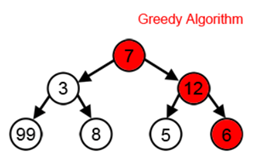

In [ ]:
########### ############### ###########